# Project 5

## Data Description:


You are given a set of portfolio companies trading data from emerging markets including 2020 Q1-Q2-Q3-Q4 2021 Q1 stock prices. Each company stock is provided in different sheets. Each market's operating days varies based on the country of the company and the market the stocks are exchanged. Use only 2020 data and predict with 2021 Q1 data.

## Goal(s):


Predict stock price valuations on a daily, weekly and monthly basis. Recommend BUY, HOLD, SELL decisions. Maximize capital returns, minimize losses. Ideally a loss should never happen. Minimize HOLD period.


## Success Metrics:


Evaluate on the basis of capital returns. Use Bollinger Bands to measure your systems effectiveness.

Plan: 
1 - Data preparation
2 - Exploratory Data Analysis 
3 - Feature engineering
4 - Model selection
5 - Decision making
<!-- Data Preparation:

Combine all the different sheets into a single dataset.
Check for any missing or null values and handle them appropriately.
Convert the date column to a datetime format for easy manipulation.
Extract the day, week, and month from the date column for daily, weekly, and monthly predictions.

Exploratory Data Analysis (EDA):

Conduct a comprehensive EDA to identify patterns, trends, and outliers in the data.
Use visualizations such as line plots, scatter plots, histograms, and box plots to explore the data.
Calculate basic statistics such as mean, median, standard deviation, and correlation to gain insights into the data.

Feature Engineering:

Create new features such as moving averages, exponential moving averages, and Bollinger Bands to help capture trends and patterns in the data.
Use technical indicators such as Relative Strength Index (RSI), Moving Average Convergence Divergence (MACD), and Stochastic Oscillator to create additional features.

Model Selection:

Select appropriate models such as Linear Regression, Random Forest Regression, and Support Vector Regression (SVR) to predict the stock prices.
Train the models using the 2020 data and test them on the 2021 Q1 data.
Use evaluation metrics such as Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and R-squared to evaluate the performance of the models.

Decision Making:

Use the predicted stock prices to make BUY, HOLD, or SELL decisions.
Calculate the capital returns based on the decisions made.
Use Bollinger Bands to measure the effectiveness of the system.
Minimize the HOLD period by adjusting the decision-making criteria based on the performance of the system -->

In [ ]:
#!pip install statsmodels --upgrade
#!pip install TA-Lib
#!pip install fbprophet
#!pip install pmdarima

In [1]:
# linear algebra
import numpy as np 

# data processing
import pandas as pd 

# data visualization
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import style

import re
from pylab import rcParams
import statsmodels.api as sm

import talib as ta

import itertools

# Algorithms

from prophet import Prophet
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

from keras.models import Sequential
from keras.layers import Dense, LSTM


# #Cross validation
# from sklearn.model_selection import KFold, cross_val_score

# #Other
# from sklearn import metrics
# from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.metrics import classification_report
# from sklearn.feature_selection import SelectKBest, chi2
# from sklearn.preprocessing import PolynomialFeatures
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import accuracy_score

# #class imbalance
# from sklearn.metrics import f1_score
# from sklearn.utils import resample


Importing plotly failed. Interactive plots will not work.


# 1 - Data preparation

In [2]:
def clean_sheets(og_data, num):
    def remove_letters(val):
        if isinstance(val, str):
            num = re.findall(r"\d+\.?\d*", val)
            if len(num) > 0:
                num = float(num[0])
                if "K" in val:
                    num /= 1000
                elif "M" in val:
                    num *= 1
                return num
        return val
    data = og_data.parse(num)
    # remove the last row as it contains text
    data.drop([data.shape[0]-1], axis=0, inplace=True)
    #clean up date column
    data[["Date"]] = data[["Date"]].apply(pd.to_datetime)
    #clean up Vol column
    data['Vol.'] = data['Vol.'].apply(remove_letters)
    #make columns numeric
    data[["Price", "Open", "High", "Low", 'Vol.', "Change %"]] = data[["Price", "Open", "High", "Low", 'Vol.', "Change %"]].apply(pd.to_numeric)
    # Set the 'Date' column as the index
    data.set_index('Date', inplace=True)
    # make the Date values the index
    data = data.sort_values(by=['Date'], ascending=True)
    print(data.head())
        # Check data types of columns
    print(data.dtypes)

    # Check for missing values
    print(data.isnull().sum())
    return data

In [3]:
og_data = pd.ExcelFile('2020Q1Q2Q3Q4-2021Q1.xlsx')

In [4]:
data1 = clean_sheets(og_data, 1)

            Price   Open   High    Low  Vol.  Change %
Date                                                  
2020-01-02  20.38  20.42  20.44  20.24  2.53    0.0030
2020-01-03  20.30  20.30  20.44  19.97  3.31   -0.0039
2020-01-06  20.08  20.34  20.34  19.97  1.94   -0.0108
2020-01-07  19.93  20.22  20.28  19.92  2.89   -0.0075
2020-01-08  19.94  19.89  19.95  19.66  2.79    0.0005
Price       float64
Open        float64
High        float64
Low         float64
Vol.        float64
Change %    float64
dtype: object
Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
dtype: int64


In [5]:
data1.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2020-01-02,20.38,20.42,20.44,20.24,2.53,0.0030
2020-01-03,20.30,20.30,20.44,19.97,3.31,-0.0039
2020-01-06,20.08,20.34,20.34,19.97,1.94,-0.0108
2020-01-07,19.93,20.22,20.28,19.92,2.89,-0.0075
2020-01-08,19.94,19.89,19.95,19.66,2.79,0.0005


In [6]:
data1.tail()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2021-03-25,20.02,20.50,20.86,20.02,15.93,-0.0148
2021-03-26,19.25,20.28,20.36,19.10,21.35,-0.0385
2021-03-29,19.10,19.24,19.67,19.10,16.56,-0.0078
2021-03-30,19.50,19.12,19.81,19.03,21.05,0.0209
2021-03-31,19.41,19.42,19.63,19.27,13.14,-0.0046


# 2 - Exploratory Data Analysis 

In [7]:
def exploration(df):
    
    # Summary statistics of the data
    print(df.describe())
        # Visualize data distribution of numeric columns
    df.hist(bins=10, figsize=(15, 10))
    plt.show()

    # Visualize correlation between variables
    sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
    plt.show()

    # Explore relationships between variables using scatter plots
    sns.pairplot(df, x_vars=['Price', 'Vol.'], y_vars=['Change %'], size=5, aspect=0.8, kind='scatter')
    plt.show()

            Price        Open        High         Low        Vol.    Change %
count  315.000000  315.000000  315.000000  315.000000  315.000000  315.000000
mean    17.857397   17.879397   18.146286   17.608667   11.087810    0.000149
std      2.891400    2.877779    2.944378    2.850359    8.029082    0.024198
min     12.790000   12.970000   13.110000   12.380000    1.920000   -0.099400
25%     15.010000   15.080000   15.225000   14.840000    5.685000   -0.013350
50%     17.580000   17.640000   17.860000   17.450000    8.720000    0.000700
75%     20.130000   20.190000   20.360000   19.970000   13.830000    0.014950
max     24.080000   24.380000   25.480000   23.480000   56.570000    0.078000


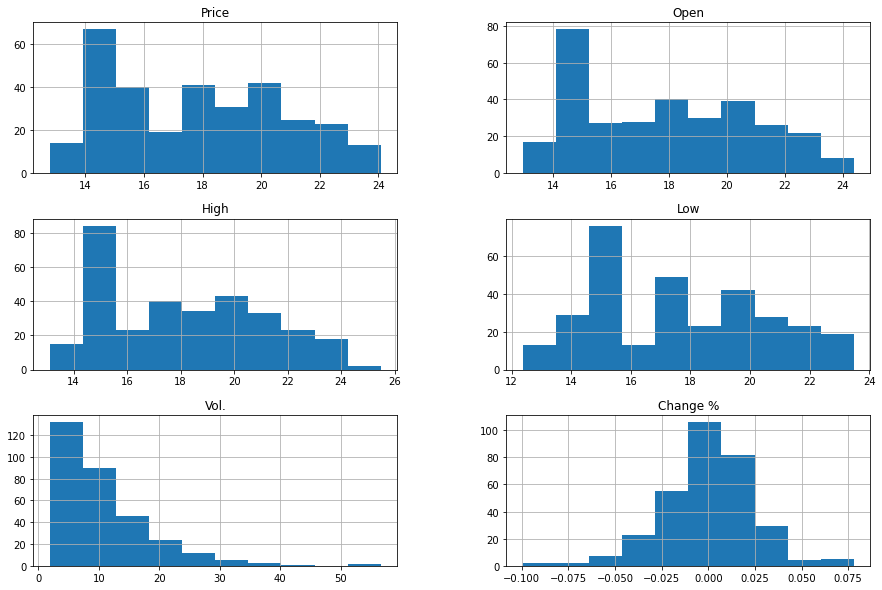

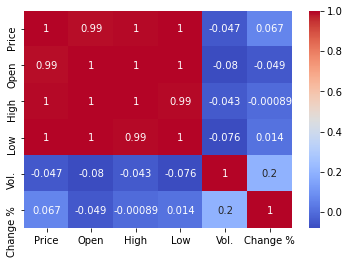

/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:1969: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


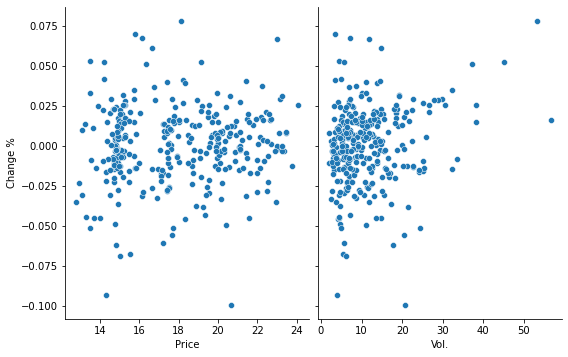

In [8]:
exploration(data1)

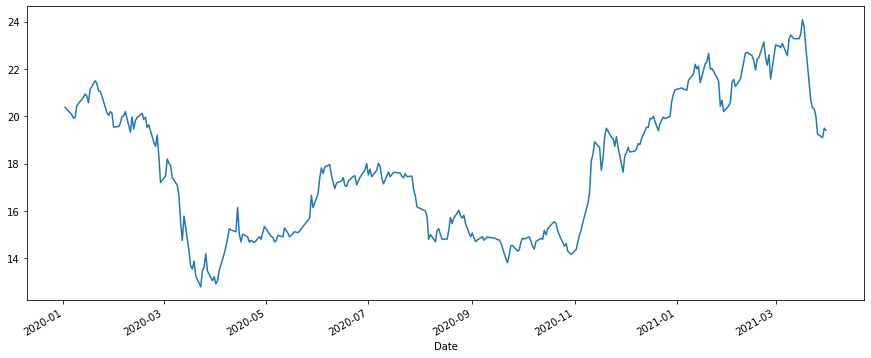

In [9]:
y = data1['Price']
y.plot(figsize=(15, 6))
plt.show()

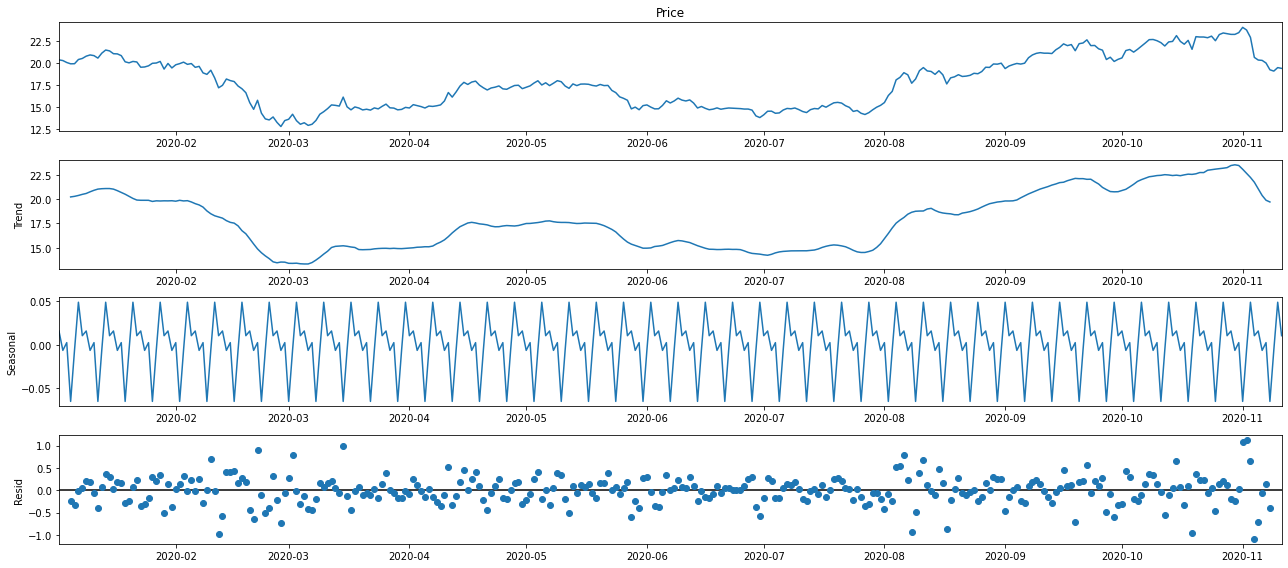

In [10]:
y.index = pd.date_range(start='2020-01-02', periods=len(y), freq='D')

rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

# 3 - Feature engineering: making weekly, monthly

In [18]:
# Resample the data on a weekly basis
data1W = data1.resample('W').last()
# Resample the data on a monthly basis 
data1M = data1.resample('M').last()

In [19]:
print(data1W)

            Price   Open   High    Low   Vol.  Change %
Date                                                   
2020-01-05  20.30  20.30  20.44  19.97   3.31   -0.0039
2020-01-12  20.54  20.54  20.70  20.26   4.38    0.0059
2020-01-19  21.14  20.60  21.14  20.40   4.18    0.0272
2020-01-26  20.86  21.26  21.28  20.62   3.49   -0.0095
2020-02-02  19.54  20.12  20.12  19.54   5.75   -0.0298
...           ...    ...    ...    ...    ...       ...
2021-03-07  23.08  22.82  23.32  22.78   6.74    0.0079
2021-03-14  23.28  23.30  23.44  23.06   5.04   -0.0034
2021-03-21  22.94  23.76  23.78  22.92  11.89   -0.0353
2021-03-28  19.25  20.28  20.36  19.10  21.35   -0.0385
2021-04-04  19.41  19.42  19.63  19.27  13.14   -0.0046

[66 rows x 6 columns]


In [20]:
data1M

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2020-01-31,19.54,20.12,20.12,19.54,5.75,-0.0298
2020-02-29,17.20,18.10,18.30,16.78,5.72,-0.0611
2020-03-31,13.22,13.14,13.42,13.06,5.64,0.0136
2020-04-30,15.34,15.20,15.55,15.10,13.68,0.0166
2020-05-31,16.14,16.58,17.00,16.14,13.14,-0.0312
2020-06-30,18.00,17.76,18.17,17.64,14.13,0.0147
2020-07-31,16.17,16.65,16.68,16.17,4.60,-0.0288
2020-08-31,14.90,15.45,15.46,14.90,17.25,-0.0362
2020-09-30,14.67,14.45,14.71,14.38,18.72,0.0230


# 4 - Models

In [21]:
data1.columns

Index(['Price', 'Open', 'High', 'Low', 'Vol.', 'Change %'], dtype='object')

In [22]:
data1.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2020-01-02,20.38,20.42,20.44,20.24,2.53,0.0030
2020-01-03,20.30,20.30,20.44,19.97,3.31,-0.0039
2020-01-06,20.08,20.34,20.34,19.97,1.94,-0.0108
2020-01-07,19.93,20.22,20.28,19.92,2.89,-0.0075
2020-01-08,19.94,19.89,19.95,19.66,2.79,0.0005


In [23]:
print(data1.iloc[-64])
print(64/len(data1))

Price       21.1200
Open        20.8400
High        21.3800
Low         20.7200
Vol.         7.1200
Change %     0.0086
Name: 2020-12-31 00:00:00, dtype: float64
0.20317460317460317


## LSTM model

In [90]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
import math
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:i+look_back, 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

def model_LSTM(dataset, look_back=1):
  
    # split into train and test sets
    train_size = int(len(dataset) * 0.8)
    test_size = len(dataset) - train_size    
    train, test = dataset[0:train_size,:], dataset[train_size-look_back:len(dataset),:]

    # reshape into X=t and Y=t+1
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)
    # reshape input to be [samples, time steps, features]
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    
    # # create and fit the LSTM network
    model = Sequential()
    model.add(LSTM(4, input_shape=(1, look_back)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
    # make predictions

    # Prepare input data
    inputs = trainX[-1:]
    print('inputs:', inputs)
    # Predict next values
    forecasts = []

    for i in range(len(testY)):
        # Forecast next value
        forecast = model.predict(inputs)
        forecast = forecast[-1][-1].round(2)
        forecasts.append(forecast)
        new = np.append(inputs[-1:,:,1:],[[[forecast]]],axis=2)

        # Update input sequence
        inputs = np.append(inputs[1:,:,:],new,axis=0)
        print(inputs)
    # Print forecasts
    print("Next values: ", forecasts)   
    print(testY)
    testScore = np.sqrt(mean_squared_error(testY, forecasts))
    print('Test Score: %.2f RMSE' % (testScore))
    testPredictPlot = np.empty_like(dataset)
    testPredictPlot[:, :] = np.nan
    forecasts = np.array(forecasts)
    forecasts = forecasts.reshape(-1, 1)
    testPredictPlot[len(train):len(dataset), :] = forecasts
    
    # plot baseline and predictions
    plt.plot(dataset, color = 'b')
    plt.plot(testPredictPlot, color = 'r')
    plt.show()

### Daily basis

In [72]:
def pre_LSTM(df):
    df = df['Price']
    data = df.values
    data = data.astype('float32')
    data = data.reshape(-1, 1)
    return data

Epoch 1/100
242/242 - 2s - loss: 260.4807 - 2s/epoch - 7ms/step
Epoch 2/100
242/242 - 0s - loss: 221.3180 - 245ms/epoch - 1ms/step
Epoch 3/100
242/242 - 0s - loss: 202.5102 - 239ms/epoch - 988us/step
Epoch 4/100
242/242 - 0s - loss: 185.9313 - 233ms/epoch - 962us/step
Epoch 5/100
242/242 - 0s - loss: 170.6553 - 239ms/epoch - 987us/step
Epoch 6/100
242/242 - 0s - loss: 156.4071 - 222ms/epoch - 915us/step
Epoch 7/100
242/242 - 0s - loss: 143.0912 - 255ms/epoch - 1ms/step
Epoch 8/100
242/242 - 0s - loss: 130.6361 - 223ms/epoch - 923us/step
Epoch 9/100
242/242 - 0s - loss: 118.9928 - 221ms/epoch - 911us/step
Epoch 10/100
242/242 - 0s - loss: 108.0967 - 224ms/epoch - 925us/step
Epoch 11/100
242/242 - 0s - loss: 97.9202 - 228ms/epoch - 940us/step
Epoch 12/100
242/242 - 0s - loss: 88.4285 - 233ms/epoch - 965us/step
Epoch 13/100
242/242 - 0s - loss: 79.5803 - 245ms/epoch - 1ms/step
Epoch 14/100
242/242 - 0s - loss: 71.3692 - 224ms/epoch - 925us/step
Epoch 15/100
242/242 - 0s - loss: 63.7715 - 

[[[18.02 16.22 14.9  14.57 13.34 13.25 12.81 11.27 11.48 11.24]]]
1/1 [==============================] - 0s 20ms/step
[[[16.22 14.9  14.57 13.34 13.25 12.81 11.27 11.48 11.24 10.3 ]]]
1/1 [==============================] - 0s 26ms/step
[[[14.9  14.57 13.34 13.25 12.81 11.27 11.48 11.24 10.3  10.54]]]
1/1 [==============================] - 0s 21ms/step
[[[14.57 13.34 13.25 12.81 11.27 11.48 11.24 10.3  10.54 11.3 ]]]
1/1 [==============================] - 0s 21ms/step
[[[13.34 13.25 12.81 11.27 11.48 11.24 10.3  10.54 11.3  10.33]]]
1/1 [==============================] - 0s 20ms/step
[[[13.25 12.81 11.27 11.48 11.24 10.3  10.54 11.3  10.33 11.95]]]
1/1 [==============================] - 0s 21ms/step
[[[12.81 11.27 11.48 11.24 10.3  10.54 11.3  10.33 11.95 11.65]]]
1/1 [==============================] - 0s 19ms/step
[[[11.27 11.48 11.24 10.3  10.54 11.3  10.33 11.95 11.65 10.58]]]
1/1 [==============================] - 0s 19ms/step
[[[11.48 11.24 10.3  10.54 11.3  10.33 11.95 11.65 10.58

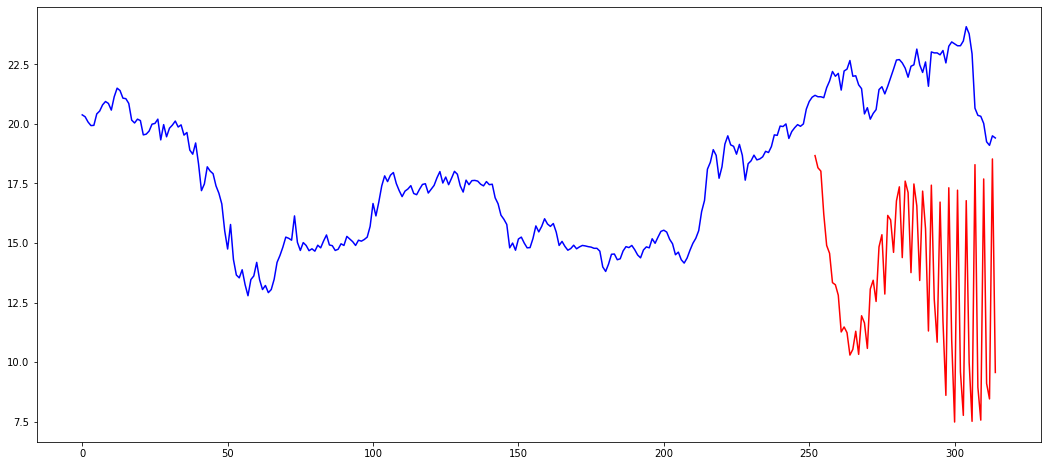

In [91]:
model_LSTM(pre_LSTM(data1), 10)

Epoch 1/100
222/222 - 2s - loss: 222.0421 - 2s/epoch - 7ms/step
Epoch 2/100
222/222 - 0s - loss: 192.8413 - 294ms/epoch - 1ms/step
Epoch 3/100
222/222 - 0s - loss: 173.8543 - 259ms/epoch - 1ms/step
Epoch 4/100
222/222 - 0s - loss: 156.4966 - 306ms/epoch - 1ms/step
Epoch 5/100
222/222 - 0s - loss: 140.5026 - 307ms/epoch - 1ms/step
Epoch 6/100
222/222 - 0s - loss: 125.7638 - 243ms/epoch - 1ms/step
Epoch 7/100
222/222 - 0s - loss: 112.2097 - 452ms/epoch - 2ms/step
Epoch 8/100
222/222 - 0s - loss: 99.7435 - 228ms/epoch - 1ms/step
Epoch 9/100
222/222 - 0s - loss: 88.3169 - 239ms/epoch - 1ms/step
Epoch 10/100
222/222 - 0s - loss: 77.8702 - 227ms/epoch - 1ms/step
Epoch 11/100
222/222 - 0s - loss: 68.3269 - 231ms/epoch - 1ms/step
Epoch 12/100
222/222 - 0s - loss: 59.6510 - 300ms/epoch - 1ms/step
Epoch 13/100
222/222 - 0s - loss: 51.8052 - 248ms/epoch - 1ms/step
Epoch 14/100
222/222 - 0s - loss: 44.7439 - 234ms/epoch - 1ms/step
Epoch 15/100
222/222 - 0s - loss: 38.4295 - 235ms/epoch - 1ms/step


1/1 [==============================] - 0s 18ms/step
[[[17.64 18.33 18.45 18.69 18.49 18.53 18.62 18.85 18.8  19.05 19.54
   19.52 19.91 19.89 20.   19.39 19.68 19.84 19.97 19.9  20.   20.62
   20.94 16.37 16.37 16.37 16.37 16.37 16.37 16.37]]]
1/1 [==============================] - 0s 18ms/step
[[[18.33 18.45 18.69 18.49 18.53 18.62 18.85 18.8  19.05 19.54 19.52
   19.91 19.89 20.   19.39 19.68 19.84 19.97 19.9  20.   20.62 20.94
   16.37 16.37 16.37 16.37 16.37 16.37 16.37 16.37]]]
1/1 [==============================] - 0s 18ms/step
[[[18.45 18.69 18.49 18.53 18.62 18.85 18.8  19.05 19.54 19.52 19.91
   19.89 20.   19.39 19.68 19.84 19.97 19.9  20.   20.62 20.94 16.37
   16.37 16.37 16.37 16.37 16.37 16.37 16.37 16.37]]]
1/1 [==============================] - 0s 18ms/step
[[[18.69 18.49 18.53 18.62 18.85 18.8  19.05 19.54 19.52 19.91 19.89
   20.   19.39 19.68 19.84 19.97 19.9  20.   20.62 20.94 16.37 16.37
   16.37 16.37 16.37 16.37 16.37 16.37 16.37 16.37]]]
1/1 [===================

   16.37 16.37 16.37 16.37 16.37 16.37 16.37 16.37]]]
1/1 [==============================] - 0s 17ms/step
[[[16.37 16.37 16.37 16.37 16.37 16.37 16.37 16.37 16.37 16.37 16.37
   16.37 16.37 16.37 16.37 16.37 16.37 16.37 16.37 16.37 16.37 16.37
   16.37 16.37 16.37 16.37 16.37 16.37 16.37 16.37]]]
1/1 [==============================] - 0s 20ms/step
[[[16.37 16.37 16.37 16.37 16.37 16.37 16.37 16.37 16.37 16.37 16.37
   16.37 16.37 16.37 16.37 16.37 16.37 16.37 16.37 16.37 16.37 16.37
   16.37 16.37 16.37 16.37 16.37 16.37 16.37 16.37]]]
1/1 [==============================] - 0s 19ms/step
[[[16.37 16.37 16.37 16.37 16.37 16.37 16.37 16.37 16.37 16.37 16.37
   16.37 16.37 16.37 16.37 16.37 16.37 16.37 16.37 16.37 16.37 16.37
   16.37 16.37 16.37 16.37 16.37 16.37 16.37 16.37]]]
1/1 [==============================] - 0s 19ms/step
[[[16.37 16.37 16.37 16.37 16.37 16.37 16.37 16.37 16.37 16.37 16.37
   16.37 16.37 16.37 16.37 16.37 16.37 16.37 16.37 16.37 16.37 16.37
   16.37 16.37 16.37 16.

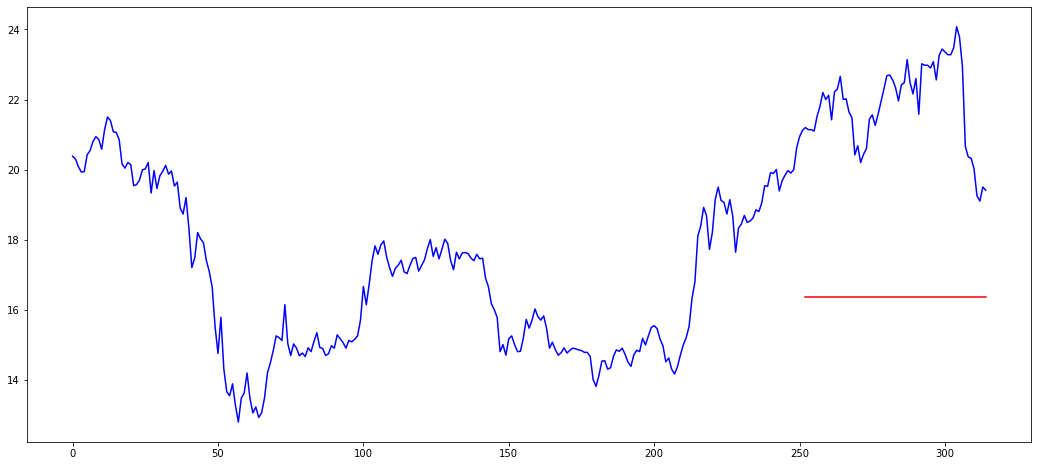

In [92]:
model_LSTM(pre_LSTM(data1), 30)

Epoch 1/100
192/192 - 2s - loss: 221.9192 - 2s/epoch - 8ms/step
Epoch 2/100
192/192 - 0s - loss: 201.4187 - 189ms/epoch - 986us/step
Epoch 3/100
192/192 - 0s - loss: 184.7550 - 181ms/epoch - 943us/step
Epoch 4/100
192/192 - 0s - loss: 169.1368 - 180ms/epoch - 937us/step
Epoch 5/100
192/192 - 0s - loss: 154.5414 - 184ms/epoch - 958us/step
Epoch 6/100
192/192 - 0s - loss: 140.9034 - 179ms/epoch - 932us/step
Epoch 7/100
192/192 - 0s - loss: 128.1496 - 196ms/epoch - 1ms/step
Epoch 8/100
192/192 - 0s - loss: 116.2549 - 205ms/epoch - 1ms/step
Epoch 9/100
192/192 - 0s - loss: 105.1677 - 232ms/epoch - 1ms/step
Epoch 10/100
192/192 - 0s - loss: 94.8549 - 196ms/epoch - 1ms/step
Epoch 11/100
192/192 - 0s - loss: 85.2808 - 177ms/epoch - 923us/step
Epoch 12/100
192/192 - 0s - loss: 76.4118 - 182ms/epoch - 947us/step
Epoch 13/100
192/192 - 0s - loss: 68.2337 - 185ms/epoch - 964us/step
Epoch 14/100
192/192 - 0s - loss: 60.6980 - 180ms/epoch - 935us/step
Epoch 15/100
192/192 - 0s - loss: 53.7707 - 209

1/1 [==============================] - 0s 22ms/step
Next values:  [16.29, 16.29, 16.29, 16.29, 16.29, 16.29, 16.29, 16.29, 16.29, 16.29, 16.29, 16.29, 16.29, 16.29, 16.29, 16.29, 16.29, 16.29, 16.29, 16.29, 16.29, 16.29, 16.29, 16.29, 16.29, 16.29, 16.29, 16.29, 16.29, 16.29, 16.29, 16.29, 16.29, 16.29, 16.29, 16.29, 16.29, 16.29, 16.29, 16.29, 16.29, 16.29, 16.29, 16.29, 16.29, 16.29, 16.29, 16.29, 16.29, 16.29, 16.29, 16.29, 16.29, 16.29, 16.29, 16.29, 16.29, 16.29, 16.29, 16.29, 16.29, 16.29, 16.29]
[21.2  21.14 21.14 21.1  21.52 21.8  22.2  22.   22.12 21.42 22.22 22.3
 22.66 22.   22.02 21.64 21.48 20.42 20.68 20.2  20.44 20.6  21.44 21.56
 21.26 21.58 21.94 22.3  22.68 22.7  22.56 22.34 21.96 22.42 22.48 23.14
 22.48 22.16 22.6  21.58 23.02 22.98 22.98 22.9  23.08 22.56 23.26 23.44
 23.36 23.28 23.28 23.48 24.08 23.78 22.94 20.66 20.36 20.32 20.02 19.25
 19.1  19.5  19.41]
Test Score: 5.71 RMSE


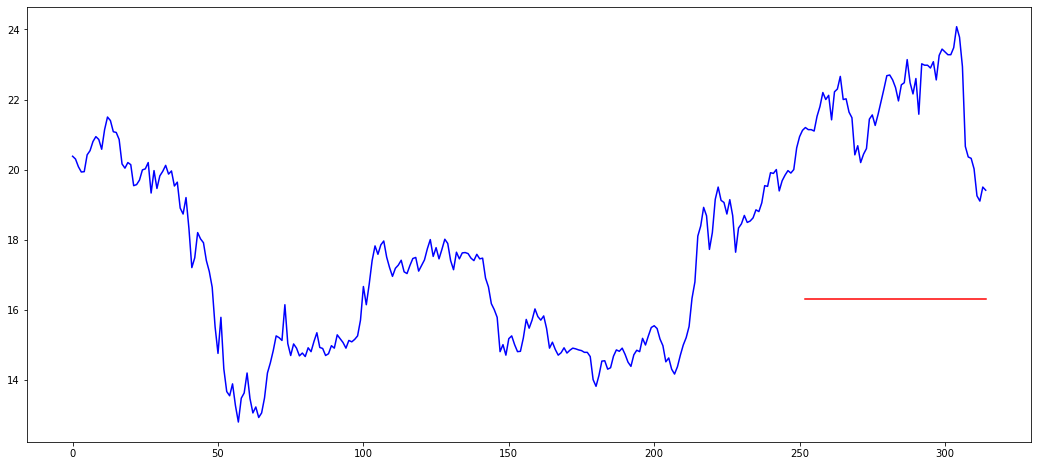

In [83]:
model_LSTM(pre_LSTM(data1), 60)

Epoch 1/100
162/162 - 2s - loss: 251.4668 - 2s/epoch - 10ms/step
Epoch 2/100
162/162 - 0s - loss: 237.3011 - 191ms/epoch - 1ms/step
Epoch 3/100
162/162 - 0s - loss: 225.2244 - 222ms/epoch - 1ms/step
Epoch 4/100
162/162 - 0s - loss: 213.6311 - 183ms/epoch - 1ms/step
Epoch 5/100
162/162 - 0s - loss: 202.5187 - 197ms/epoch - 1ms/step
Epoch 6/100
162/162 - 0s - loss: 191.8314 - 189ms/epoch - 1ms/step
Epoch 7/100
162/162 - 0s - loss: 181.5470 - 195ms/epoch - 1ms/step
Epoch 8/100
162/162 - 0s - loss: 171.6679 - 179ms/epoch - 1ms/step
Epoch 9/100
162/162 - 0s - loss: 162.1783 - 209ms/epoch - 1ms/step
Epoch 10/100
162/162 - 0s - loss: 153.0630 - 218ms/epoch - 1ms/step
Epoch 11/100
162/162 - 0s - loss: 144.3036 - 190ms/epoch - 1ms/step
Epoch 12/100
162/162 - 0s - loss: 135.8932 - 202ms/epoch - 1ms/step
Epoch 13/100
162/162 - 0s - loss: 127.8159 - 186ms/epoch - 1ms/step
Epoch 14/100
162/162 - 0s - loss: 120.0684 - 177ms/epoch - 1ms/step
Epoch 15/100
162/162 - 0s - loss: 112.6481 - 183ms/epoch - 

1/1 [==============================] - 0s 22ms/step
Next values:  [16.61, 16.61, 16.61, 16.61, 16.61, 16.61, 16.61, 16.61, 16.61, 16.61, 16.61, 16.61, 16.61, 16.61, 16.61, 16.61, 16.61, 16.61, 16.61, 16.61, 16.61, 16.61, 16.61, 16.61, 16.61, 16.61, 16.61, 16.61, 16.61, 16.61, 16.61, 16.61, 16.61, 16.61, 16.61, 16.61, 16.61, 16.61, 16.61, 16.61, 16.61, 16.61, 16.61, 16.61, 16.61, 16.61, 16.61, 16.61, 16.61, 16.61, 16.61, 16.61, 16.61, 16.61, 16.61, 16.61, 16.61, 16.61, 16.61, 16.61, 16.61, 16.61, 16.61]
[21.2  21.14 21.14 21.1  21.52 21.8  22.2  22.   22.12 21.42 22.22 22.3
 22.66 22.   22.02 21.64 21.48 20.42 20.68 20.2  20.44 20.6  21.44 21.56
 21.26 21.58 21.94 22.3  22.68 22.7  22.56 22.34 21.96 22.42 22.48 23.14
 22.48 22.16 22.6  21.58 23.02 22.98 22.98 22.9  23.08 22.56 23.26 23.44
 23.36 23.28 23.28 23.48 24.08 23.78 22.94 20.66 20.36 20.32 20.02 19.25
 19.1  19.5  19.41]
Test Score: 5.40 RMSE


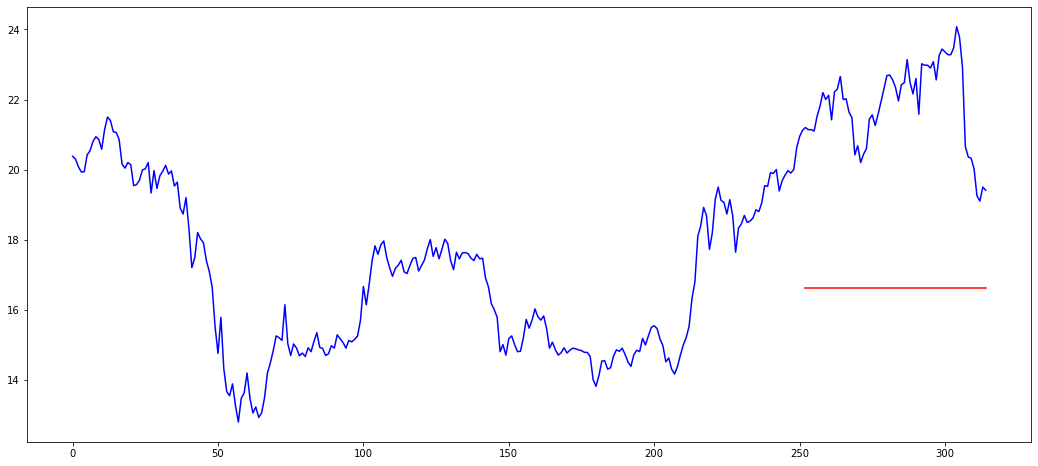

In [84]:
model_LSTM(pre_LSTM(data1), 90)

### Weekly basis

Epoch 1/100
50/50 - 1s - loss: 287.6236 - 1s/epoch - 29ms/step
Epoch 2/100
50/50 - 0s - loss: 277.3416 - 69ms/epoch - 1ms/step
Epoch 3/100
50/50 - 0s - loss: 270.4165 - 60ms/epoch - 1ms/step
Epoch 4/100
50/50 - 0s - loss: 254.3945 - 63ms/epoch - 1ms/step
Epoch 5/100
50/50 - 0s - loss: 237.2869 - 65ms/epoch - 1ms/step
Epoch 6/100
50/50 - 0s - loss: 229.7580 - 56ms/epoch - 1ms/step
Epoch 7/100
50/50 - 0s - loss: 223.6217 - 77ms/epoch - 2ms/step
Epoch 8/100
50/50 - 0s - loss: 218.0416 - 63ms/epoch - 1ms/step
Epoch 9/100
50/50 - 0s - loss: 212.7827 - 56ms/epoch - 1ms/step
Epoch 10/100
50/50 - 0s - loss: 207.7182 - 62ms/epoch - 1ms/step
Epoch 11/100
50/50 - 0s - loss: 202.8755 - 57ms/epoch - 1ms/step
Epoch 12/100
50/50 - 0s - loss: 198.1658 - 57ms/epoch - 1ms/step
Epoch 13/100
50/50 - 0s - loss: 193.6062 - 53ms/epoch - 1ms/step
Epoch 14/100
50/50 - 0s - loss: 189.1419 - 60ms/epoch - 1ms/step
Epoch 15/100
50/50 - 0s - loss: 184.7942 - 57ms/epoch - 1ms/step
Epoch 16/100
50/50 - 0s - loss: 180

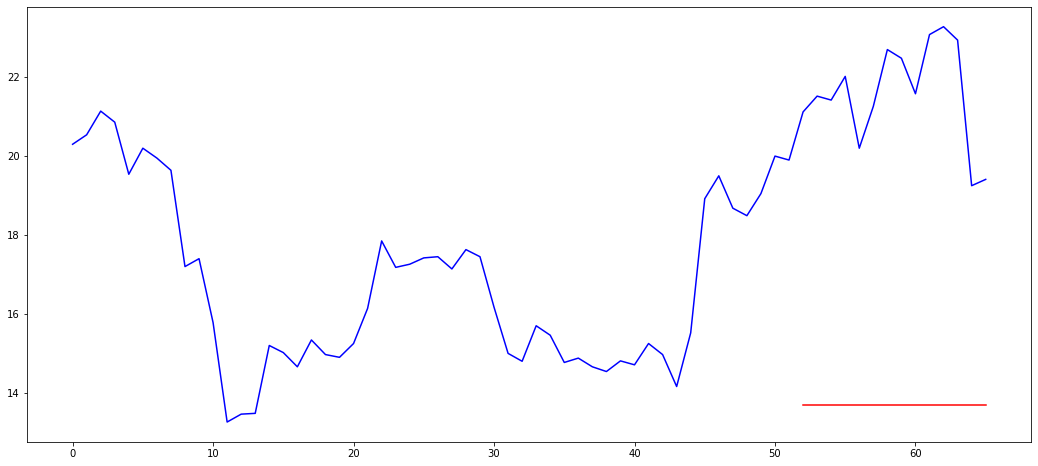

In [85]:
model_LSTM(pre_LSTM(data1W), 2)

Epoch 1/100
42/42 - 2s - loss: 233.3935 - 2s/epoch - 40ms/step
Epoch 2/100
42/42 - 0s - loss: 211.3488 - 58ms/epoch - 1ms/step
Epoch 3/100
42/42 - 0s - loss: 204.0805 - 61ms/epoch - 1ms/step
Epoch 4/100
42/42 - 0s - loss: 199.9268 - 58ms/epoch - 1ms/step
Epoch 5/100
42/42 - 0s - loss: 195.9789 - 59ms/epoch - 1ms/step
Epoch 6/100
42/42 - 0s - loss: 192.1201 - 54ms/epoch - 1ms/step
Epoch 7/100
42/42 - 0s - loss: 188.3750 - 52ms/epoch - 1ms/step
Epoch 8/100
42/42 - 0s - loss: 184.6929 - 51ms/epoch - 1ms/step
Epoch 9/100
42/42 - 0s - loss: 181.0906 - 51ms/epoch - 1ms/step
Epoch 10/100
42/42 - 0s - loss: 177.5305 - 63ms/epoch - 2ms/step
Epoch 11/100
42/42 - 0s - loss: 174.0421 - 56ms/epoch - 1ms/step
Epoch 12/100
42/42 - 0s - loss: 170.6211 - 51ms/epoch - 1ms/step
Epoch 13/100
42/42 - 0s - loss: 167.2241 - 57ms/epoch - 1ms/step
Epoch 14/100
42/42 - 0s - loss: 163.9205 - 56ms/epoch - 1ms/step
Epoch 15/100
42/42 - 0s - loss: 160.6297 - 54ms/epoch - 1ms/step
Epoch 16/100
42/42 - 0s - loss: 157

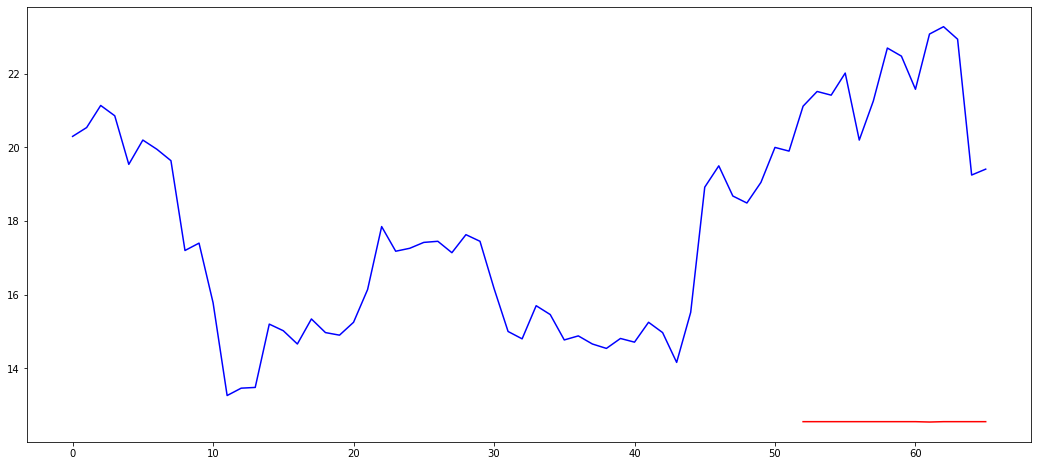

In [86]:
model_LSTM(pre_LSTM(data1W), 10)

### Monthly basis

Epoch 1/100
11/11 - 2s - loss: 268.2269 - 2s/epoch - 142ms/step
Epoch 2/100
11/11 - 0s - loss: 267.7488 - 16ms/epoch - 1ms/step
Epoch 3/100
11/11 - 0s - loss: 267.2928 - 16ms/epoch - 1ms/step
Epoch 4/100
11/11 - 0s - loss: 266.8576 - 18ms/epoch - 2ms/step
Epoch 5/100
11/11 - 0s - loss: 266.4195 - 14ms/epoch - 1ms/step
Epoch 6/100
11/11 - 0s - loss: 265.9906 - 17ms/epoch - 2ms/step
Epoch 7/100
11/11 - 0s - loss: 265.5298 - 17ms/epoch - 2ms/step
Epoch 8/100
11/11 - 0s - loss: 265.0700 - 25ms/epoch - 2ms/step
Epoch 9/100
11/11 - 0s - loss: 264.5346 - 18ms/epoch - 2ms/step
Epoch 10/100
11/11 - 0s - loss: 263.9207 - 20ms/epoch - 2ms/step
Epoch 11/100
11/11 - 0s - loss: 263.1143 - 16ms/epoch - 1ms/step
Epoch 12/100
11/11 - 0s - loss: 262.0295 - 21ms/epoch - 2ms/step
Epoch 13/100
11/11 - 0s - loss: 260.4826 - 18ms/epoch - 2ms/step
Epoch 14/100
11/11 - 0s - loss: 258.2542 - 19ms/epoch - 2ms/step
Epoch 15/100
11/11 - 0s - loss: 255.3251 - 18ms/epoch - 2ms/step
Epoch 16/100
11/11 - 0s - loss: 25

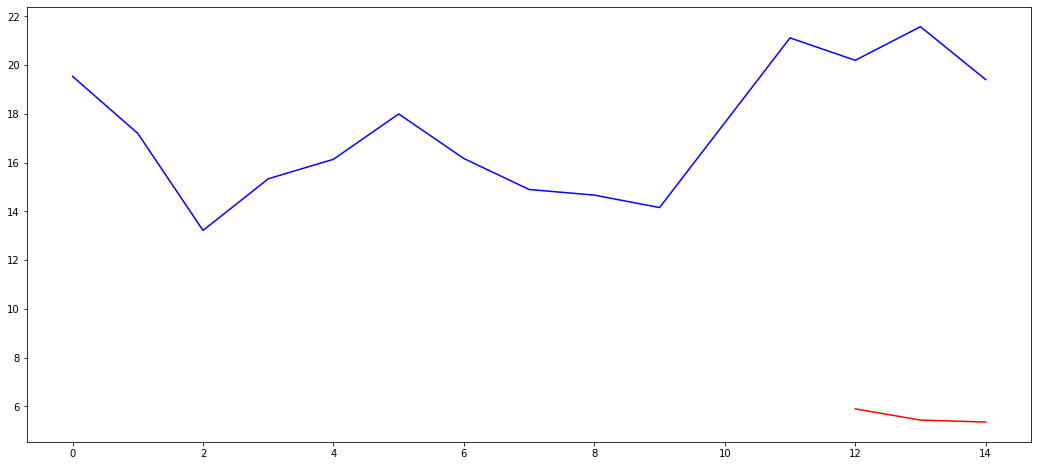

In [87]:
model_LSTM(pre_LSTM(data1M), 1)

Epoch 1/100
9/9 - 1s - loss: 239.0638 - 1s/epoch - 162ms/step
Epoch 2/100
9/9 - 0s - loss: 238.1180 - 20ms/epoch - 2ms/step
Epoch 3/100
9/9 - 0s - loss: 237.2681 - 24ms/epoch - 3ms/step
Epoch 4/100
9/9 - 0s - loss: 236.4657 - 23ms/epoch - 3ms/step
Epoch 5/100
9/9 - 0s - loss: 235.6458 - 24ms/epoch - 3ms/step
Epoch 6/100
9/9 - 0s - loss: 234.8532 - 29ms/epoch - 3ms/step
Epoch 7/100
9/9 - 0s - loss: 233.9464 - 19ms/epoch - 2ms/step
Epoch 8/100
9/9 - 0s - loss: 232.8429 - 29ms/epoch - 3ms/step
Epoch 9/100
9/9 - 0s - loss: 231.3334 - 24ms/epoch - 3ms/step
Epoch 10/100
9/9 - 0s - loss: 228.7705 - 30ms/epoch - 3ms/step
Epoch 11/100
9/9 - 0s - loss: 224.4343 - 22ms/epoch - 2ms/step
Epoch 12/100
9/9 - 0s - loss: 218.2833 - 26ms/epoch - 3ms/step
Epoch 13/100
9/9 - 0s - loss: 211.8480 - 19ms/epoch - 2ms/step
Epoch 14/100
9/9 - 0s - loss: 206.8880 - 16ms/epoch - 2ms/step
Epoch 15/100
9/9 - 0s - loss: 203.7517 - 15ms/epoch - 2ms/step
Epoch 16/100
9/9 - 0s - loss: 201.5199 - 14ms/epoch - 2ms/step
E

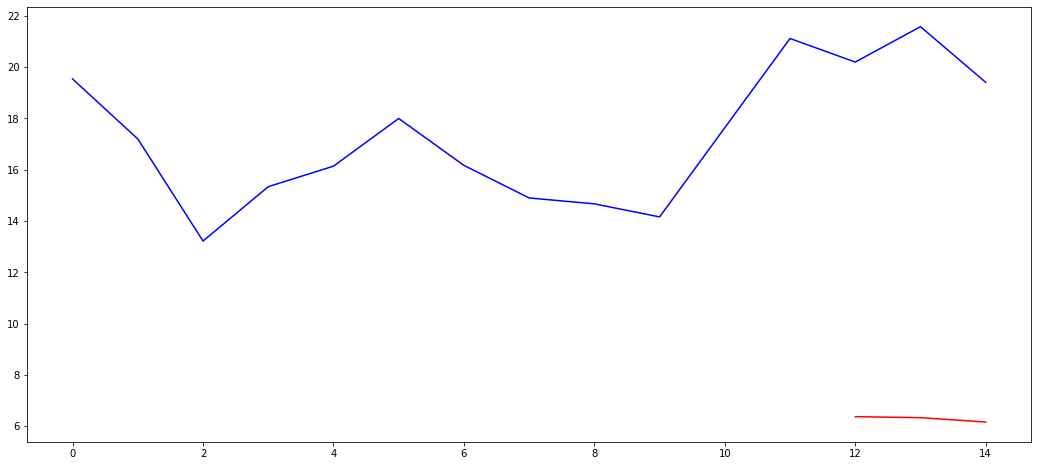

In [88]:
model_LSTM(pre_LSTM(data1M), 3)

Multi-Step LSTM Models?


Vector Output Model?
Encoder-Decoder Model?

## Auto-ARIMA model

In [ ]:
from pmdarima import auto_arima

In [ ]:
def auto_ARIMA(dataframe):
    # split into train and test sets
    train = dataframe[:int(0.8*(len(dataframe)))]
    valid = dataframe[int(0.8*(len(dataframe))):]
   
    model = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True)
    model.fit(train)

    forecast = model.predict(n_periods=len(valid))
    forecast = pd.DataFrame(forecast,index = valid.index,columns=['Prediction'])

    #plot the predictions for validation set
    plt.plot(train, label='Train', color = 'b')
    plt.plot(valid, label='Valid', color = 'g')
    plt.plot(forecast, label='Prediction', color = 'r')
    plt.show()

In [ ]:
auto_ARIMA(data1['Price'])

In [ ]:
auto_ARIMA(data1W['Price'])

In [ ]:
auto_ARIMA(data1M['Price'])

## Prophet model

In [ ]:
def model_prophet(df):
    
    # Prepare the data for Prophet
    df = df.rename(columns={'Price': 'y'})
    df = df.reset_index().rename(columns={'Date': 'ds'})
    
    # split into train and test sets
    train = df[:int(0.8*(len(df)))]
    test = df[int(0.8*(len(df))):]

    # Create a Prophet model and fit it to the data
    model = Prophet()
    model.fit(train)

    # Make predictions for the next 365 days
    future = model.make_future_dataframe(periods=len(test))
    forecast = model.predict(future)

    # Plot the forecast
#     model.plot(forecast)

    #plot the predictions for validation set
    plt.plot(df['y'])
    plt.plot(forecast['yhat'])
    plt.show()

In [ ]:
forecast = model_prophet(data1)

In [ ]:
model_prophet(data1W)

In [ ]:
model_prophet(data1M)